# Understanding just enough of matplotlib...

### (or, Why a State Machine within a State Machine is a Shitty Idea)

<br>

So, you want to plot something in Python. Perhaps you've typed 

```python 
import matplotlib.pyplot as plt
```

a few times...maybe you even managed to format your axis ticklabels for a special plot. Do you have a few examples lying around where you once used matplotlib to do something, but you don't quite remember _why_ it worked?

This tutorial is for you. We will assume that you can follow the [simple plotting tutorials](http://matplotlib.org/users/pyplot_tutorial.html). Instead, we will try to understand the ideas _behind_ matplotlib's structure, but only enough to develop intuition for efficiently switching between simple, high-level commands and all the glorious guts beneath. 

This intuition requires an understanding of the different roles of **pyplot**, **backends**, and the **matplotlib API**. We'll start by understanding backends, why they're confusing, and how we can stop thinking about them. We'll then see how convenient pylot is, and what its limitations are. We'll end with a dive into the matplotlib object space. Expect some bouncing back-and-forth between concepts and explicit examples.

Requirements:

`matplotlib`, `numpy`

# A Simple Example

Let's start with an example from the tutorials.

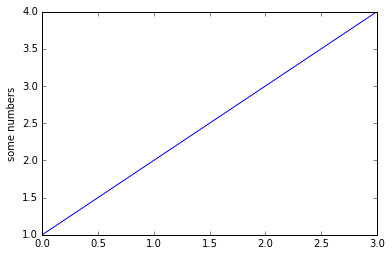

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([1,2,3,4])
plt.ylabel('some numbers')
plt.show()

Observations:
* we've used an ipython "magic" function to do something to matplotlib
* we've imported the pyplot module and used some functions defined in it
* there's nothing object-oriented here: we called 3 stand-alone functions, sequentially
* yet the `show` function caused the plot to render in a jupyter notebook.

Lots of magic here...

# Some background

Matplotlib consists of 3 groups of Python objects:
1. pyplot: a set of command-style functions to provide MATLAB-style interface
2. Matplotlib API / frontend: classes that do the heavy lifting, creating and managing figures, text, lines, plots and so on. 
3. Backend: device dependent resources for turning abstract graphical objects into pixels

**Efficient, effective use of matplotlib involves: configuring the backend correctly, using pyplot when possible, and dropping into the API when necessary.**

Foundational ideas: (http://matplotlib.org/faq/usage_faq.html)

Environmental hierarchy:
* Pyplot state machine: it knows about what you’ve plotted (for purely programmatic use, this may be dropped as irrelevant [or unhelpful!])
* pyplot functions that look like: `matplotlib.pyplot.FUNCTION`
* Figure - associates Axes objects and the Canvas (a lower-level object)
* Axes - a plot, plus a few things like a title
* Axis - number-line-like: ticks, ticklabels, etc.
* Plotting input is always one or more numpy.array objects
* Backends combine a rendering engine (PNG,SVG,etc) with an environment awareness

<img src="files/fig_map.png">

# Peeling away the magic...

The cell below is same example as above, but more verbose: the pyplot state machine maintains knowledge 
 of what was plotted with `plot`, such that a call to `show` renders the figure, and the
 `%matplotlib` magic command handles the backend (object to pixel mapping, display, inline figure embedding). We've also made the namespaces really explicit.

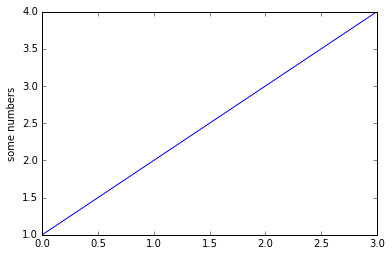

In [18]:
import matplotlib.pyplot
%matplotlib inline

matplotlib.pyplot.plot([1,2,3,4])
matplotlib.pyplot.ylabel('some numbers')
#matplotlib.pyplot.show()

It turns out that we don't even need the call to `show` because of what the `%matplotlib` call does.

We can remove the magic function if we specify the backend with an explicit 'write' call. This is a good example of how pyplot and the backend manage separate concerns.

**Restart kernel here if you want to prove it actually works.**

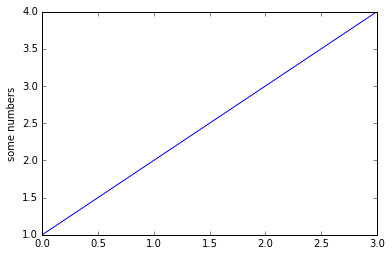

In [19]:
import matplotlib.pyplot

matplotlib.pyplot.plot([1,2,3,4])
matplotlib.pyplot.ylabel('some numbers')
matplotlib.pyplot.savefig('test.png')

Look for `test.png` in your local directory. 

What have we done? There's still the pyplot state machine (running in the ipython state machine!), but we've made explicit some of the magic the `%matplotlib inline` call was performing. There are other arguments for `%matplotlib` including `notebook`, which provides a more interactive inline plot, see http://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=magic#magic-matplotlib

[OPTIONAL]

We can also set the backend explicitly; see http://matplotlib.org/faq/usage_faq.html#what-is-a-backend. You'll need to restart your kernel again and uncomment the code in the cell below.

In [23]:
#import matplotlib
#matplotlib.use('TkAgg')

#import matplotlib.pyplot

#matplotlib.pyplot.plot([1,2,3,4])
#matplotlib.pyplot.ylabel('some numbers')
#matplotlib.pyplot.show()

That's all we'll say about backends. You have options for how and where to render your plots: you can make use of the magic `%matplotlib` function, which sets an appropriate backend and does the inline plotting, or you can write your plots explicitly to files. We'll do the former here.

# Moving between pyplot and the matplotlib API

You can find lots of neat plotting examples at http://matplotlib.org/examples/index.html. Most of them involve both `pyplot` function calls and operations on matplotlib API objects. The pattern is simple:

```python
    matplotlib.OBJECT() = matplotlib.pyplot.FUNCTION()
    
```

Let's go back to our example, in which we were discarding the return values of the pyplot functions.

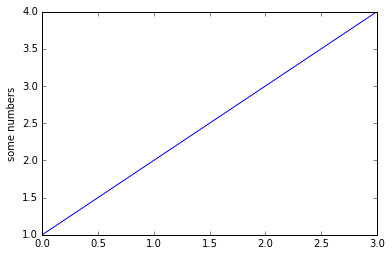

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# call to 'plot' returns a tuple of Line2D objects
line, = plt.plot([1,2,3,4])
# call to 'ylabel' returns a Text object
text = plt.ylabel('some numbers')

`line` is an object representing the line on the chart and all of its properties. Because it's an object, we can use its methods to modify the line.

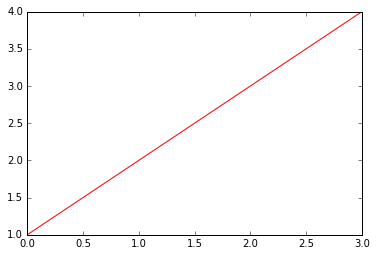

In [21]:
# Here's an example of a setter method
line, = plt.plot([1,2,3,4])
line.set_color('r')

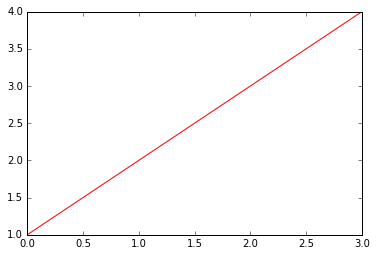

In [22]:
# and here's the pyplot way of doing the same thing:
_ = plt.plot([1,2,3,4],'r')

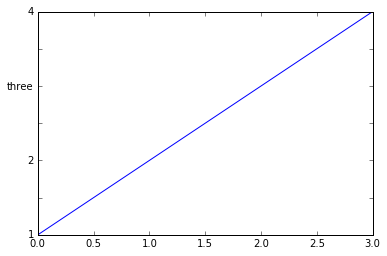

In [23]:
# an example of some getter methods
line, = plt.plot([1,2,3,4])
axes = line.axes
y_axis = axes.get_yaxis()

# And another setter (and getter) call
labels = y_axis.set_ticklabels([1,'',2,'','three','',4])

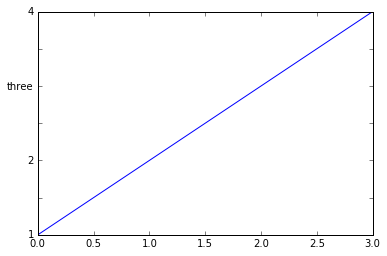

In [24]:
# and the pyplot version
import numpy as np
plt.plot([1,2,3,4])
_ = plt.yticks(np.arange(1,4.5,0.5),(1,'',2,'','three','',4))

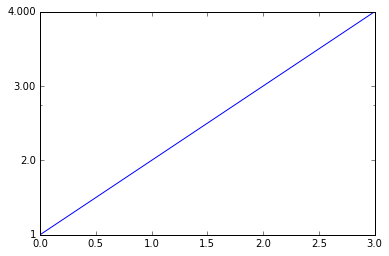

In [27]:
# now for something really crazy
import matplotlib.ticker as ticker

# plot and get the y-axis
line, = plt.plot([1,2,3,4])
axes = line.axes
y_axis = axes.get_yaxis()

# I want major tick marks at integer y-values (meh, just use pyplot)
_ = plt.yticks(range(1,5))

# I want a single, un-labeled, minor tick at y = 2.75
y_axis.set_minor_locator( ticker.FixedLocator([2.75]))

# I want proportional precision in my y-labels
def func(x,pos): 
    """ 
    return a string representation of `x` with floating point precision `pos`
    """
    return_str = '{0:.' + str(pos) + 'f}'
    return return_str.format(x)

tick_formatter = ticker.FuncFormatter( func )
labels = y_axis.set_major_formatter(tick_formatter)

What do we observe?

* pyplot functions are convenient, even when dealing with API objects
* the pyplot namespace is flat, while the API namespace is hiearchical
* somethings you just _can't_ do with pyplot


# The matplotlib API

We've seen how pyplot functions interact with maplotlib API by returning objects. Now we'll briefly note the 3 layers of classes that make the API work.

* Canvas - the area onto which the figure is drawn

Inherits from `matplotlib.backend_bases.FigureCanvas`

* Renderer - the object which knows how to draw on the Canvas

Inherits from `matplotlib.backend_bases.Renderer`

* Artists - the object that knows how to use a renderer to paint onto the canvas

Inherits from `matplotlib.artist.Artist`

`Artist` objects handle all the high level constructs like representing and laying out the figure, text, and lines. Almost all objects interacted with are Artists, including container-like objects such as `Figure`, `Axes`, `Axis`, and graphical primitives such as `Rectangle`, `Line2D`, and `Text`. 

<img src="files/fig_map.png">

`Axes` objects are one of the most important API components, because they are the containers that hold and reference most other objects. The `Axes` class provides helpful interface methods like `plot` and `hist` which create primitive `Artist` instances, like `Line2D`, from input numpy arrays and strings.  

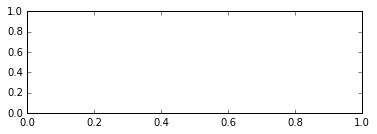

In [28]:
import matplotlib.pyplot as plt

# use pyplot to get a figure
fig = plt.figure()
# create an array of Axes objects and get the specified one
ax = fig.add_subplot(2,1,1) # two rows, one column, first plot

Note above that there is a `Subplot` class, and that inherits from `Axes`.

A `Figure` can place an `Axes` at an arbitrary location with the `add_axes` method. 

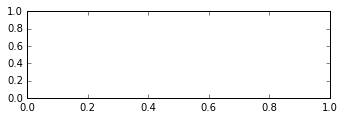

In [29]:
fig2 = plt.figure()
ax2 = fig2.add_axes([0.15, 0.1, 0.7, 0.3])

Let's make some dummy data.

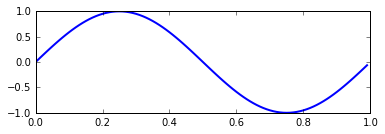

In [30]:
# have to recreate the figure and subplots because inline plotting is opaque.

fig = plt.figure()
ax = fig.add_subplot(2,1,1)

t = np.arange(0.0, 1.0, 0.01)
s = np.sin(2*np.pi*t)
line, = ax.plot(t, s, color='blue', lw=2)

Now, let's compare the 'line' object, a `Line2D` instance, to the graphical primitives that the `Axes` knows about.

In [31]:
ax.lines[0]

In [32]:
line

As expected (hoped for?), they are the same object. 

## Helper libraries

In addition to modules that define common Artists, the API contains a bunch of modules that provide helper classes around a particular topic. You saw an example earlier when we imported `matplotlib.ticker` and used its Locator and Formatter classes. 

Other examples are (http://matplotlib.org/api/index.html):

* dates
* units
* finance
* legend
* colors
* animation

Most of what is implemented in these modules are additional Artists, which can delegate their rendering to the same classes used by other Artists. 

# Final Example

Let's dig into an example that uses the `colors` module. There are patterns of use here that are typical across the API. See documentation and examples at http://matplotlib.org/examples/color/colormaps_reference.html.

Goal: make a dynamic set of curves with different colors, and label the curves by their RGB values.

Why? Suppose you have an unknown number of curves that will display on a dashboard. To distinguish them, you'll need to _dynamically_ assign _distinguishable_ colors.

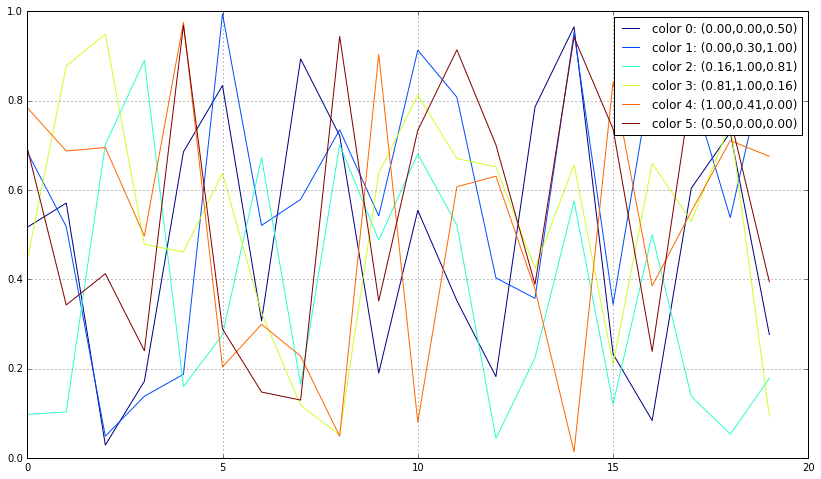

In [33]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np

%matplotlib inline

# some random data:
NCURVES = 6
np.random.seed(101)
# each curve consists of 20 points with random values in [0,1]
curves = [np.random.random(20) for i in range(NCURVES)]

# make one Subplot/Axes object in the figure,
# and make the figure a bit bigger
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

# use pyplot to get a color map
jet = plt.get_cmap('jet') 

# make an object that represent a normalization onto a range
color_normalizer = colors.Normalize(vmin=0, vmax=len(curves)-1)

# an object to map scalar data in the range specified by the normalizer
# to a color on the specified color map
scalar_map = cmx.ScalarMappable(norm=color_normalizer,cmap=jet)

for idx in range(len(curves)):
    # get the np.array
    line = curves[idx]
    # map it to a color value
    color_val = scalar_map.to_rgba(idx)

    # make the legend text
    color_text = (
        'color {0}: ({1:4.2f},{2:4.2f},{3:4.2f})'.format(idx,color_val[0],color_val[1],color_val[2])
        )
    
    # use Axes.plot to plot it
    _ = ax.plot(line,
                color=color_val,
                label=color_text)

# legend stuff
handles,labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right')
ax.grid()
#plt.show()

# Final Things

* Use pyplot when possible and to get access to underlying API objects
    * there are lots of convenience functions, e.g. `plt.tight_layout()`
    * its flat namespace is convenient for simple things, but can only do so much
* `Artist` objects include graphical primitives (lines, text), container objects (axes), and helper classes defined in auxiliary modules (like `DateFormatter` in `matplotlib.dates`).
    * they typically contain property getter and setter methods, as well a functions that return associated objects.
* There are _lots_ of matplotlib/pyplot examples and tutorials.

# Extra Credit

Modify the script above to color the line by the curve's maximum value. Use a color map that makes the ordering obvious.